# Fitting rings to the 2008 and 2011 eclipses of PDS 110
Manually fitting ring edges to PDS 110 data from Osborn et al. (2017) MNRAS accepted.

This notebook produces Figure 5 for the paper.

**M Kenworthy** *2017 May 30* // Leiden Observatory // kenworthy@strw.leidenuniv.nl


In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import exorings3

# set sensible imshow defaults
mpl.rc('image', interpolation='nearest', origin='lower', cmap='gray')
mpl.rc('axes.formatter', limits=(-7,7))

mpl.rcParams.update({'font.size': 18})

# print all numpy floats to 2 decimal places
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})


## Read in WASP and KELT light curves and normalise them

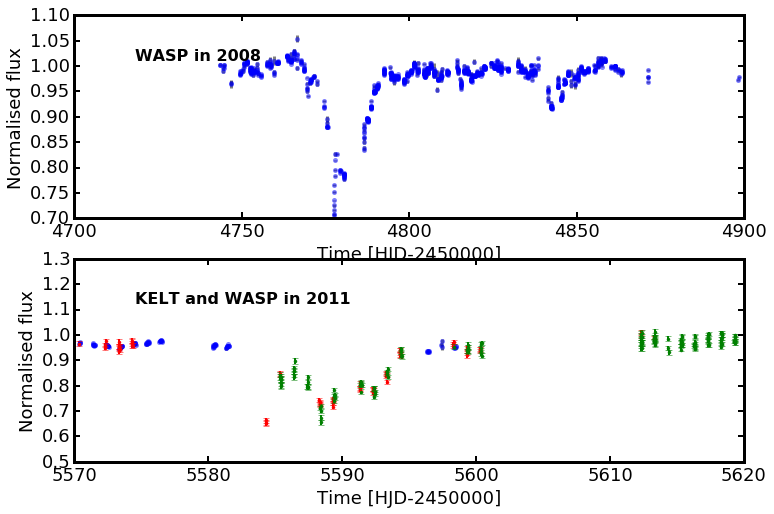

In [2]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax3 = fig.add_subplot(212)

# WASP
from j0523 import *
(t_wasp, f_wasp_c, ferr_wasp_c) = read_swasp_binned_cleaned()

# this normalises the WASP flux
wasp_scale = 70.
f_wasp = f_wasp_c / wasp_scale
ferr_wasp = ferr_wasp_c / wasp_scale

# KELT
from astropy.io import ascii
from astropy.time import Time

kelte = ascii.read('lc_016130_mag.data.raw.airmass',
                  names=['jd','mag','magerr','am'])
keltw = ascii.read('lc_018222_mag.data.raw.airmass',
                  names=['jd','mag','magerr','am'])
te = Time(kelte['jd'],format='jd')
tw = Time(keltw['jd'],format='jd')

# there's a systematic offset between East and West cameras in KELT
dmag = -0.12

#ax2.errorbar(te.jyear,kelte['mag'],kelte['magerr'],fmt='.',color='red')
#ax2.errorbar(tw.jyear,keltw['mag']+dmag,keltw['magerr'],fmt='.',color='green')

m0_kelt = 13.00 # full illuminated flux for the star in KELT

kelte_flux = np.power(10., (kelte['mag'] - m0_kelt) / -2.5)
keltw_flux = np.power(10., (keltw['mag'] + dmag - m0_kelt) / -2.5)

kelte_err = kelte['magerr']
keltw_err = keltw['magerr']

(t_wasp, f_wasp_c, ferr_wasp_c) = read_swasp_binned_cleaned()

# wasp_scale is 70 for all seasons, but it's lower for just the eclipse (probably due to fluctuations in the star)
wasp_scale = 67.
f_wasp = f_wasp_c / wasp_scale
ferr_wasp = ferr_wasp_c / wasp_scale

# errorbars definiton
tc = dict(marker='.',ecolor='black', capsize=0 ,
    elinewidth=3, ms=10, alpha = 0.5, markeredgecolor='none',
    markeredgewidth=0.0, linewidth=0.0)

# text in left and corner
tyb = dict(color='black', fontsize=16, fontweight='bold', va='top')


ax1.set_xlim(4700,4900)
ax1.text(0.09, 0.84, 'WASP in 2008', transform=ax1.transAxes, **tyb)
ax1.errorbar(t_wasp, f_wasp, ferr_wasp, mfc='blue', **tc)
ax1.set_xlabel('Time [HJD-2450000]')
ax1.set_ylabel('Normalised flux')

ax3.set_xlim(5570,5620)
ax3.text(0.09, 0.84, 'KELT and WASP in 2011', transform=ax3.transAxes, **tyb)
ax3.errorbar(t_wasp, f_wasp, ferr_wasp, mfc='blue', **tc)

ax3.errorbar(te.jd-2450000.,kelte_flux,kelte_err,fmt='.',color='red')
ax3.errorbar(tw.jd-2450000.,keltw_flux,keltw_err,fmt='.',color='green')
ax3.set_xlabel('Time [HJD-2450000]')
ax3.set_ylabel('Normalised flux')


## Combine KELT photometry from East and West cameras
The 2011 eclipse is mostly KELT data with some WASP data. In this notebook, I'm calling the 2008 eclipse `WASP` data and the 2011 eclipse the `KELT` data.

In [3]:
t_kelt = np.append(te.jd,tw.jd) - 2450000.
f_kelt = np.append(kelte_flux, keltw_flux)
ferr_kelt = np.append(kelte_err, keltw_err)

## ADDING THE WASP photometry to the KELT photometry...
t_kelt = np.append(t_kelt, t_wasp)
f_kelt = np.append(f_kelt, f_wasp)
ferr_kelt = np.append(ferr_kelt, ferr_wasp)


## Measure nightly gradient in a time series
This function splits a photometric time series into nightly chunks and fits a straight line to the whole night of data.
It returns the measured slopes and an error on the slope.

It also plots a shaded rectangle on a supplied axis instance so that you can check you are only selecting the data of one night.

In [4]:
def measure_nightly_gradient(t_center_night, t_ring_range, t_wasp, f_wasp, ferr_wasp, ax):

    from matplotlib import patches
    
    tt = np.arange(t_center_night-t_ring_range, t_center_night+t_ring_range+0.05, 1)

    tmidpt = np.array([])
    tflux = np.array([])
    tslope = np.array([])
    tsloperr = np.array([])
    for (tlower,tupper) in zip(tt-0.5,tt+0.5):
        ax.add_patch(
            patches.Rectangle(
                (tlower+0.05, 0.5),   # (x,y)
                0.90,          # width
                0.6,          # height
                facecolor='0.4',
                edgecolor='none',
                zorder=-20
            )
        )

        # select points in this range
        ts = (t_wasp > tlower) * (t_wasp < tupper)
        if (ts.sum()>4):
            tsel = t_wasp[ts]
            tmean = np.mean(tsel)
            fsel = f_wasp[ts]
            fesel = ferr_wasp[ts]
            line, pcov = np.polyfit(tsel-tmean, fsel, 1, w=1./fesel, cov=True)
            p = np.poly1d(line)
            ax.plot(tsel, p(tsel-tmean), color='green',linewidth=3)
            tmidpt = np.append(tmidpt, tmean)
            tflux = np.append(tflux, line[1])
            tslope = np.append(tslope, line[0])
            tsloperr = np.append(tsloperr, pcov[0][0]**0.5)

            
    return(tmidpt,tflux,tslope,tsloperr)

## Measure the nightly light curve gradients in 2008 and 2011 data

(-0.1, 1.0)

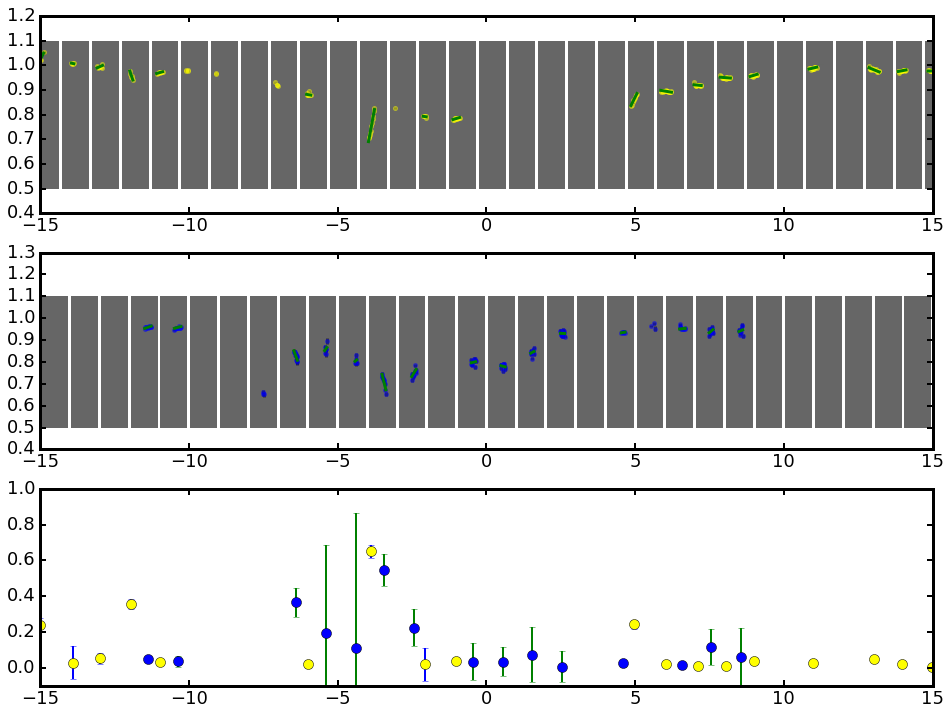

In [5]:
P = 810.3 # orbital period of the companion in days
t_cen_wasp = 4781.5 # center of WASP eclipse 
t_cen_kelt = t_cen_wasp +  P # center of WASP eclipse 

# parameters for boxing the gradients
t_ring_range = 15

t_wasp_zeroed = t_wasp-t_cen_wasp
t_kelt_zeroed = t_kelt-t_cen_kelt

fig3 = plt.figure(figsize=(16,12))

f1 = fig3.add_subplot(311)
f2 = fig3.add_subplot(312, sharex=f1)
f3 = fig3.add_subplot(313, sharex=f1)

f1.set_xlim([-t_ring_range,t_ring_range])
            
f1.errorbar(t_wasp_zeroed, f_wasp, ferr_wasp, mfc='yellow', **tc)
f2.errorbar(t_kelt_zeroed, f_kelt, ferr_kelt, mfc='blue', **tc)

(tmid_wasp, tflux_wasp, tslope_wasp, tserr_wasp) = \
    measure_nightly_gradient(0.2, t_ring_range, t_wasp_zeroed, f_wasp, ferr_wasp, f1)

(tmid_kelt, tflux_kelt, tslope_kelt, tserr_kelt) = \
    measure_nightly_gradient(0.5, t_ring_range, t_kelt_zeroed, f_kelt, ferr_kelt, f2)
    
f3.errorbar(tmid_wasp, np.abs(tslope_wasp), tserr_wasp, mfc='yellow',ms=10, fmt='.', marker='o')
f3.errorbar(tmid_kelt, np.abs(tslope_kelt), tserr_kelt, mfc='blue', ms=10, fmt='.', marker='o')

f3.set_xlim([-t_ring_range,t_ring_range])
f3.set_ylim([-0.1, 1.0])
 

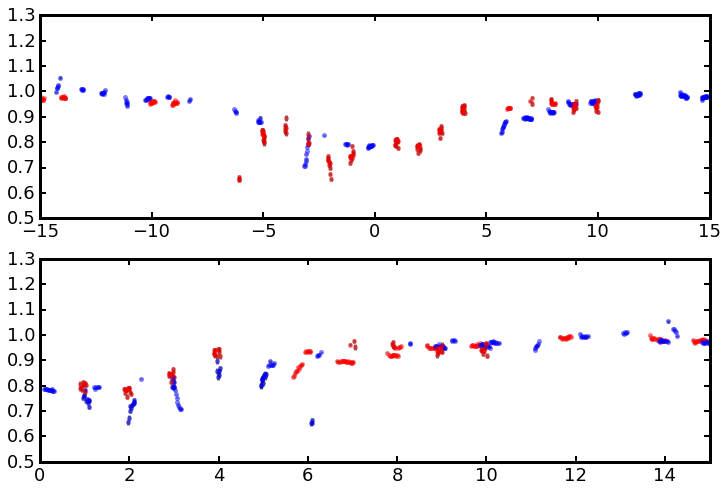

In [6]:
def plot_folded(t, f, ferr, t_fold, t_range, ax):
    """plot a light curve folded at the point t_fold, blue before, red after
    t, f, fe - x-axis, flux, flux_error
    t_fold - point to fold the light curve
    t_range - x-axis plotting range
    ax - axis to plot to
    """
    ingress = (t<t_fold)
    egress  = (t>t_fold)

    ax.errorbar(np.abs(t_fold-t[ingress]), f[ingress], ferr[ingress],mfc='blue', **tc)
    ax.errorbar(np.abs(t[egress]-t_fold), f[egress], ferr[egress],mfc='red', **tc)
    ax.set_xlim((0,t_range))

def plot_kelt_wasp(delt_cen, delt_P): 
    P = 810.3 # orbital period of the companion in days
    t_cen_wasp = 4781.5 + delt_cen # center of WASP eclipse 
    t_cen_kelt = t_cen_wasp +  P + delt_P # center of KELT eclipse 

    t_ring_range = 15
    
    t_wasp_zeroed = t_wasp-t_cen_wasp
    t_kelt_zeroed = t_kelt-t_cen_kelt

    fig3 = plt.figure(figsize=(12,8))

    f1 = fig3.add_subplot(211)
    f2 = fig3.add_subplot(212)

    f1.set_xlim([-t_ring_range,t_ring_range])
            
    f1.errorbar(t_wasp_zeroed, f_wasp, ferr_wasp, mfc='blue', **tc)
    f1.errorbar(t_kelt_zeroed, f_kelt, ferr_kelt, mfc='red', **tc)

    plot_folded(t_wasp_zeroed, f_wasp, ferr_wasp, 0.0, t_ring_range, f2)
    plot_folded(t_kelt_zeroed, f_kelt, ferr_kelt, 0.0, t_ring_range, f2)


from ipywidgets import *

w = interactive(plot_kelt_wasp, delt_cen= widgets.FloatSlider( value=-0.8, min=-5., max=5., step=0.1, description='delt_cen:',
    disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f',
    slider_color='white'), delt_P = widgets.FloatSlider(
    value=-0.6,
    min=-5.,
    max=5.,
    step=0.1,
    description='delt_P:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    slider_color='white'
))
from IPython.display import display
display(w)

## IMPORTANT: Put your final values of `delt_cen` and `delt_P` in the cell below

In [7]:
delt_cen = -0.8   # MNRAS paper number
delt_P = -0.6

## Fit disk parameters to ring gradients
Use the derived gradients to get the disk geometry parameters.

Optimization terminated successfully.
         Current function value: 12.220284
         Iterations: 353
         Function evaluations: 608
(<matplotlib.collections.LineCollection object at 0x1100e12b0>,)
Disk geometry
Impact parameter (days): 2.45
Ring center      (days): 4.02
Disk inclination (degs): 74.76
Disk skyrotation (degs): 158.62
Disk obliquity   (degs): 104.17


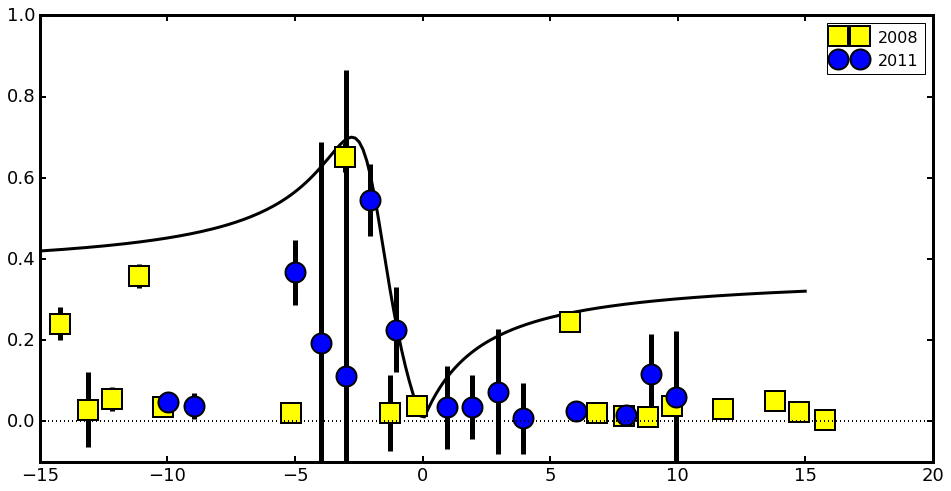

In [8]:
def ringfunc(taun, *args):
    'cost function for ring fit to photometric data'
    (t, f, f_err, rad_ri, re, k, dst) = args
    # convolve and make smoothed ring photometry
    strip, dummy, g = exorings3.ellipse_strip(rad_ri, \
        exorings3.y_to_tx(taun), re[0], re[1], re[2], re[3], k, dst)

    # interpolate the smoothed curve....
    ring_model = interp1d(g[0], g[1], kind='linear')

    # ... to the times of the photometry
    ring_model_phot = ring_model(t)

    # calculate the residuals and the chi squared
    diff = f - ring_model_phot
    chisq = np.sum(np.power(diff/f_err, 2))
    red_chisq = chisq / diff.size

    return red_chisq


def costfunc(x, *args):
    (y, dt, i_deg, phi_deg) = x
    (grad_t, grad_mag_n, t0) = args
    # grad_time
    (tmp, grad_disk_fit) = exorings3.ring_grad_line(grad_t, y, dt, i_deg, phi_deg)

    # lazy way of calculating the time midpoint of the light curve
    rmintime = np.arange(np.min(grad_t), np.max(grad_t), 0.01)
    (tmp, rminline) = exorings3.ring_grad_line(rmintime, y, dt, i_deg, phi_deg)
    rmint = rmintime[np.argmin(rminline)]

    # make a cost function
    delta = grad_disk_fit - grad_mag_n

    # if delta is positive, keep it
    # if delta is negative, make it positive and multiply by 50
    delta[np.where(delta < 0)] = -delta[np.where(delta < 0)] * 50.

    # dean is penalty to clamp rmint to be close as possible to t0
    dean = np.abs(rmint - t0)
    cost = np.sum(delta) + (dean * 20)

    return cost

from scipy.optimize import fmin
#     P = 810.3 # orbital period of the companion in days
#    t_cen_wasp = 4781.5 + delt_cen # center of WASP eclipse 
#    t_cen_kelt = t_cen_wasp +  P + delt_P # center of KELT eclipse     
#    t_wasp_zeroed = t_wasp-t_cen_wasp
#    t_kelt_zeroed = t_kelt-t_cen_kelt


# initial guess for disk fitting parameter   
y = 3.
dt =3.0
i_deg = 70.
phi_deg = 150.

# t_cen is the midpoint of the eclipse/min radius of the rings point
# forced by the routine

t_cen = 0.0

# tmid_wasp and tmid_kelt are with respect to 4781.5 and P, so
# they need to be adjusted for delt_p and delt_cen
grad_time = np.append(tmid_wasp-delt_cen, tmid_kelt-delt_cen-delt_P)
grad_mag = np.abs(np.append(tslope_wasp, tslope_kelt))
grad_mag_norm = grad_mag / np.max(grad_mag)

args=(grad_time, grad_mag_norm, t_cen)

res = fmin(costfunc, np.array([y, dt, i_deg, phi_deg]), maxiter=50000, \
    args=(grad_time, grad_mag_norm, t_cen))

fig4 = plt.figure(figsize=(16,8))

f2 = fig4.add_subplot(111)

# errorbars definiton
td = dict(fmt='.',ecolor='black', capsize=0 ,
    elinewidth=5, ms=20, markeredgecolor='black',
    markeredgewidth=2.0, linewidth=0.0, zorder=-3)

wasp_dot = f2.errorbar(tmid_wasp-delt_cen, np.abs(tslope_wasp), tserr_wasp, mfc='yellow', marker='s', **td)
kelt_dot = f2.errorbar(tmid_kelt-delt_cen-delt_P, np.abs(tslope_kelt), tserr_kelt, mfc='blue', marker='o', **td)

# draw on ring gradient
t_grad_plot = np.linspace(-t_ring_range, t_ring_range, 200.)

(_, grad_plot) = exorings3.ring_grad_line(t_grad_plot, res[0], res[1], res[2], res[3])

f2.plot(t_grad_plot, np.abs(grad_plot)*0.70,color='k',linewidth=3, zorder=-5)

# adding a legend
plt.legend([wasp_dot, kelt_dot], ["2008", "2011"],fontsize=16)
f2.set_ylim(-0.1,1.0)
plt.axhline(y=0.0, linewidth=2, linestyle='dotted', color='k')
exorings3.print_disk(res)

## Select the photometry for the ring fitting
Combine all photometry into a single time series with `t=0` marking the centre of both eclipses.

In [9]:
# combine both the kelt and wasp photometry
      
t_wake = np.append(t_wasp_zeroed-delt_cen, t_kelt_zeroed-delt_cen-delt_P)
f_wake = np.append(f_wasp, f_kelt)
ferr_wake = np.append(ferr_wasp, ferr_kelt)

t_sel = (t_wake > (t_cen-t_ring_range)) * (t_wake < (t_cen+t_ring_range))

time_sel = t_wake[t_sel]
phot_sel = f_wake[t_sel]
phot_err_sel = ferr_wake[t_sel]

print('Number of photometric points selected within t_ring_range is {}'.format(phot_sel.size))

Number of photometric points selected within t_ring_range is 359


## Calculate the stellar diameter in units of days


In [10]:
Mstar = 1.70  # msol \pm 0.1 from Osborn 2017
Rstar = 2.27  # +- 0.42 Rsun from osborn 2017
Mb = 40.0 # secondary in Mjup # reasonable lower bound for Hill sphere
Pb = P / 365.25 # secondary period

G = 6.6738480e-11 # m3 kg-1 s-2
yr = 365.242189669 * 86400  # sec
msol = 1.98855e30 # kg
rsol = 6.5500e8 # m
mjup = 1.8986e27 # kg
rjup = 6.9911e7 # m
mearth = 5.97219e24 # kg
mmoon = 7.3476e22 # kg
au = 1.49597870700e11 # m
pc = 3.0856e16 # m

def Ptoa(P,m1,m2):
    """calculate orbital radius from period

    P period (years)
    m1 mass of primary (M_sol)
    m2 mass of secondary (M_jup)

    returns
    a semi-major axis (AU)
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)
    c = G / (4. * np.pi * np.pi)
    mu = (m1 * msol) + (m2 * mjup)
    a3 = np.power(P * yr, 2.) * (c * mu)
    return(np.power(a3,1./3.) / au)

def vcirc(m1,m2,a):
    """ Circular orbital velocity of m2 about m1 at distance a
        m1 in Solar masses
        m2 in Jupiter masses
        a in AU
        returns v in m/s
    """

    # http://en.wikipedia.org/wiki/Circular_orbit

    mu = G * ((m1*msol) + (m2*mjup))
    vcirc = np.power((mu / (a*au)), 0.5)
    return(vcirc)

# convert to an orbital velocity
a = Ptoa(Pb, Mstar, Mb)
v = vcirc(Mstar, Mb, a)

dstar = (Rstar * rsol * 2 / v) / 86400.
print('Diameter of star is {:.2f} days'.format(dstar))
print('Circular orbital velocity is {:.2f} km/s'.format(v/1000.))

# convert velocity to au per day
vaupd = v * 86400. / au

print('Circular orbital velocity is {:.4f} au/d'.format(vaupd))

kern = exorings3.make_star_limbd(25, 0.8) # kernel for a limb darkened star
kern = kern / np.sum(kern)

Diameter of star is 1.25 days
Circular orbital velocity is 27.46 km/s
Circular orbital velocity is 0.0159 au/d


In [11]:
def plot_folded_models(t_fold, t_range, yt, ax, npoi=900):
    """plot a light curve folded at the point t_fold, blue before, red after
    t_fold - point to fold the light curve
    t_range - x-axis plotting range
    ax - axis to plot to
    npoi - number of points along model curve
    needs tb, i_deg, phi_deg, kern, d_star
    """
    t = np.linspace(t_fold-t_range, t_fold+t_range, npoi)
    yin = np.ones_like(t) * yt

    ingress = (t<t_fold)
    egress  = (t>t_fold)

    (flout) = exorings3.ellipse_stellar(t, yin, rad_samp, exorings3.y_to_tx(txy_samp), tb, i_deg, phi_deg, kern, d_star)

    ax.plot(np.abs(t_fold-t[ingress]), flout[ingress], c='blue')
    ax.plot(np.abs(t[egress]-t_fold), flout[egress], c='red')
    
    (flout_nostar) = exorings3.ellipse_stellar(t, yin, rad_samp, exorings3.y_to_tx(txy_samp), tb, i_deg, phi_deg, kern, 0.0001)
    
    ax.plot(np.abs(t_fold-t), flout_nostar, color='orange')
  

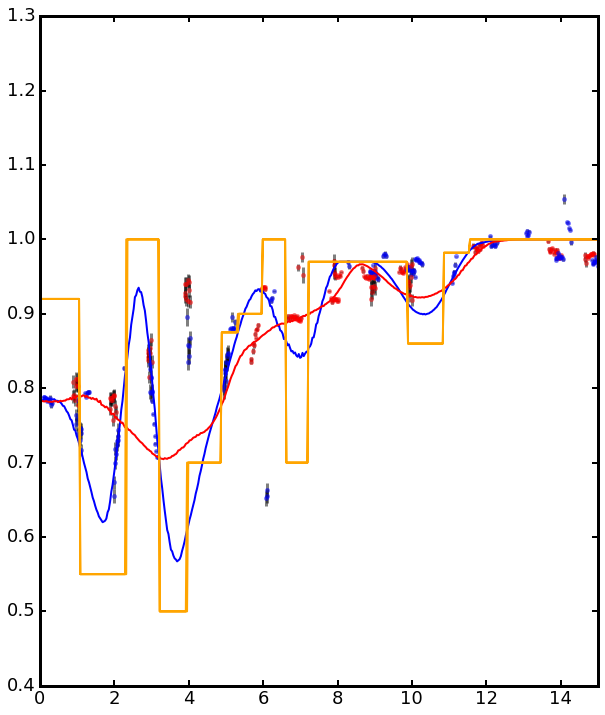

In [12]:
# initial guess is a ramp of transmission
rad_samp = np.linspace(4.,17.,15)
tx_samp  = np.linspace(0.75,1.0,rad_samp.size)
txy_samp = exorings3.tx_to_y(tx_samp)

(yt, tb, i_deg, phi_deg) = res

# manually adjust rings
txy_samp[2]=exorings3.tx_to_y(0.92)
txy_samp[3]=exorings3.tx_to_y(0.55)
txy_samp[4]=exorings3.tx_to_y(1.00)
txy_samp[5]=exorings3.tx_to_y(0.5)
txy_samp[6]=exorings3.tx_to_y(0.7)

txy_samp[8]=exorings3.tx_to_y(0.90)
txy_samp[9]=exorings3.tx_to_y(1.00)
txy_samp[10]=exorings3.tx_to_y(0.70)
txy_samp[11]=exorings3.tx_to_y(0.97)
txy_samp[12]=exorings3.tx_to_y(0.86)


#rad_samp[3] = rad_samp[3] + 0.5
#rad_samp[4] = rad_samp[4] + 0.4
#rad_samp[5] = rad_samp[5] + 0.1
rad_samp[6] = rad_samp[6] + 0.3
rad_samp[11] = rad_samp[11] + 3.2
rad_samp[12] = rad_samp[12] + 3.8
rad_samp[13] = rad_samp[13] + 4
rad_samp[14] = rad_samp[14] + 4

t_fold = t_cen

t = np.linspace(t_fold-t_ring_range, t_fold+t_ring_range, 900)
yin = np.ones_like(t) * yt

ingress = (t<t_fold)
egress  = (t>t_fold)
(flout) = exorings3.ellipse_stellar(t, yin, rad_samp, exorings3.y_to_tx(txy_samp), tb, i_deg, phi_deg, kern, dstar)

multi = plt.figure(figsize=(10,12))
f5 = multi.add_subplot(111)

plot_folded(t_wasp_zeroed-delt_cen, f_wasp, ferr_wasp, t_cen, t_ring_range, f5)
plot_folded(t_kelt_zeroed-delt_cen-delt_P, f_kelt, ferr_kelt, t_cen, t_ring_range, f5)

f5.plot(np.abs(t_fold-t[ingress]), flout[ingress], c='blue')
f5.plot(np.abs(t[egress]-t_fold), flout[egress], c='red')
    
(flout_nostar) = exorings3.ellipse_stellar(t, yin, rad_samp, exorings3.y_to_tx(txy_samp), tb, i_deg, phi_deg, kern, 0.0001)
    
f5.plot(np.abs(t_fold-t), flout_nostar, color='orange')


## Make Figure 5 for the paper

center of eclipse in 2008 is 4780.7
center of eclipse in 2008 is 5590.4


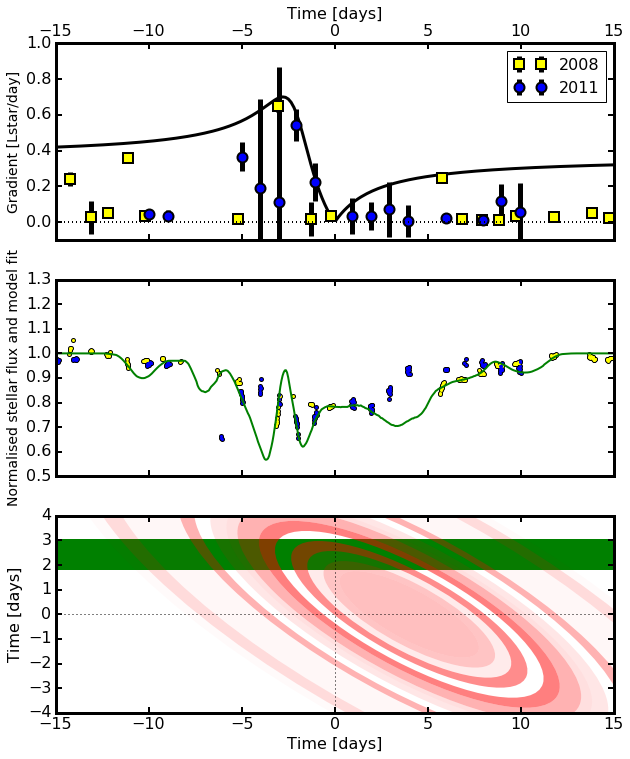

In [13]:
multi = plt.figure(figsize=(10,12))

# the gradients and the best fit
pan1 = multi.add_subplot(311)

plt.tick_params(axis='both', labeltop='on', labelright='off', labelbottom='off', labelsize=16)

pan1.xaxis.set_label_position("top")
pan1.set_xlabel('Time [days]', fontsize=16)

pan1.set_ylabel('Gradient [Lstar/day]', fontsize=14)
pan1.set_ylim([-0.08,0.8])

# errorbars definiton
td = dict(fmt='.',ecolor='black', capsize=0 ,
    elinewidth=5, ms=10, markeredgecolor='black',
    markeredgewidth=2.0, linewidth=0.0, zorder=-3)
wasp_dot = pan1.errorbar(tmid_wasp-delt_cen, np.abs(tslope_wasp), tserr_wasp, mfc='yellow', marker='s', **td)
kelt_dot = pan1.errorbar(tmid_kelt-delt_cen-delt_P, np.abs(tslope_kelt), tserr_kelt, mfc='blue', marker='o', **td)

# draw on ring gradient
t_grad_plot = np.linspace(-t_ring_range, t_ring_range, 200.)

(_, grad_plot) = exorings3.ring_grad_line(t_grad_plot, res[0], res[1], res[2], res[3])

pan1.plot(t_grad_plot, np.abs(grad_plot)*0.70,color='k',linewidth=3, zorder=-5)

# adding a legend
plt.legend([wasp_dot, kelt_dot], ["2008", "2011"],fontsize=16)
pan1.set_ylim(-0.1,1.0)
plt.axhline(y=0.0, linewidth=2, linestyle='dotted', color='k')

# photometry and the best fit
pan2 = multi.add_subplot(312,sharex=pan1)
plt.tick_params(axis='both', labeltop='off', labelright='off', labelbottom='off', labelsize=16)


P = 810.3 # orbital period of the companion in days
t_cen_wasp = 4781.5 + delt_cen # center of WASP eclipse 
t_cen_kelt = t_cen_wasp +  P + delt_P # center of KELT eclipse 
t_wasp_zeroed = t_wasp-t_cen_wasp
t_kelt_zeroed = t_kelt-t_cen_kelt
print("center of eclipse in 2008 is {}".format(t_cen_wasp))
print("center of eclipse in 2008 is {}".format(t_cen_kelt))
pan2.set_ylabel('Normalised stellar flux and model fit', fontsize=14)

# plot the wasp and KELT photometry

tc = dict(marker='.',ecolor='black', capsize=0,
    markeredgecolor='black',
    markeredgewidth=2.0, linewidth=0.0)

plt.errorbar(t_wasp_zeroed, f_wasp, ferr_wasp, mfc='yellow', zorder=-12, **tc)
plt.errorbar(t_kelt_zeroed, f_kelt, ferr_kelt, mfc='blue', zorder=-12, **tc)

tc = dict(marker='.',ecolor='black', capsize=0,
    markeredgecolor='none',
    markeredgewidth=0.0, linewidth=0.0)

plt.errorbar(t_wasp_zeroed, f_wasp, ferr_wasp, mfc='yellow',  zorder=-10, **tc)
plt.errorbar(t_kelt_zeroed, f_kelt, ferr_kelt, mfc='blue', zorder=-10, **tc)

# calculate and plot the best fit model
t = np.linspace(t_cen-t_ring_range, t_cen+t_ring_range, 500)
yin = np.ones_like(t) * yt
(flout) = exorings3.ellipse_stellar(t, yin, rad_samp, exorings3.y_to_tx(txy_samp), tb, i_deg, phi_deg, kern, dstar)
plt.plot(t,flout,color='green', zorder=-5)

pan3 = multi.add_subplot(313,sharex=pan1)
pan3.tick_params(axis='both', which='major', labelsize=14)

# plot out the rings
exorings3.draw_rings_vector(rad_samp, exorings3.y_to_tx(txy_samp), tb, i_deg, phi_deg, pan3, xrang=30, yrang=30)
plt.axhline(linewidth=1, linestyle='dotted', color='k')

from matplotlib.patches import Rectangle

pan3.add_patch(Rectangle((t_cen-t_ring_range, yt-(dstar/2.)), t_ring_range*2, dstar, facecolor="green", zorder=-20, linewidth=0))

plt.axvline(linewidth=1, linestyle='dotted', color='k')

# axes are tied, so adjusting pan3 x-axis changes all panels
pan3.set_xlim([t_cen-15, t_cen+15])
pan3.set_ylim([-4,4])

plt.tick_params(axis='both', labelsize=16)

pan3.set_xlabel('Time [days]', fontsize=16)
pan3.set_ylabel('Time [days]', fontsize=16)

plt.savefig('fig05.pdf', bbox_inches='tight', pad_inches=0.1)



## Print disk geometry and calculate obliquity and diameter

In [14]:
exorings3.print_disk(res)
print(t_cen)
# have to do 90-i_deg because i=90 means edge on planet orbit, and if the rings are in the plane of the orbit,
# obliquity should be zero as well.
# also with 180-phi_deg, because we want phi_deg to be between -90 and 90 for the correct obliquity
# and we don't know which way round the rings are orbiting w.r.t the planet orbit
# so this makes the obliquity sit in the 0 to 90 range.


obl = exorings3.obliquity(90-i_deg, 180-phi_deg)
print(' ring plane obliquity is {:.1f} degs'.format(obl))

# size of ring system is max radius multipled by vaupd * 2
disk_diam = rad_samp[-1] * 2 * vaupd
print(' disk diameter is {:.1f} days == {:.2f} au'.format(rad_samp[-1]*2,disk_diam))

Disk geometry
Impact parameter (days): 2.45
Ring center      (days): 4.02
Disk inclination (degs): 74.76
Disk skyrotation (degs): 158.62
Disk obliquity   (degs): 104.17
0.0
 ring plane obliquity is 26.0 degs
 disk diameter is 42.0 days == 0.67 au
